# Figure generation

## Imports

In [1]:
from figure_utils.fishbait_figures import PlotKFoldSingleBarUsingWAvgPreds, PlotKFoldComboBarUsingWAvgPreds, PlotKFoldResidualHistUsingWAvgPreds
from figure_utils.fishbait_figures import PlotBaseModelLossfunResults, PlotPCA_CLSProjection
from figure_utils.fishbait_figures import PlotQSARresidualScatter, PlotQSARcompBarUsingWAvgPredsInterersect, PlotQSARcompScatter, PlotQSARCoverageComboBar, PlotQSARComp3inOne
from figure_utils.preprocess_data import Preprocess10x10Fold, GroupDataForPerformance
from figure_utils.preprocess_qsar import LoadQSAR, MatchQSAR, PrepareQSARData

In [2]:
import numpy as np
import pandas as pd

## Make figures

### Non species specific

In [ ]:
INSIDE_AD = True
ENDPOINT = 'EC50'

if INSIDE_AD:
    AD = 'AD'
else:
    AD = 'allpreds'

save_figures = True

if save_figures == True:
    PlotQSARComp3inOne(savepath = f"./figures_for_publication/{ENDPOINT}/allspecies_weightedavgpreds_10x10CV_QSAR_comp_{AD}_SMILES_effect", endpoint=ENDPOINT,inside_AD=INSIDE_AD,use_weighted_avg=True)
else:
    PlotQSARComp3inOne(savepath = None, endpoint=ENDPOINT,inside_AD=INSIDE_AD,use_weighted_avg=True)

### Non endpoint specific

In [3]:
SPECIES_GROUP = 'invertebrates'

In [4]:
def PlotNonEndpointSpecific(combomodel, species_group, save_figures: bool=False):

    if save_figures:

        PlotKFoldComboBarUsingWAvgPreds(f"./figures_for_publication/combo_model_{combomodel}_performance_10x10_CV", combomodel, species_group)
        PlotKFoldSingleBarUsingWAvgPreds(f"./figures_for_publication/{species_group}_single_model_performance_10x10_CV", ec50_name=f'EC50_{species_group}', ec10_name=f'EC10_{species_group}')
        for inside_AD in [True, False]:
            if inside_AD:
                AD='AD'
            else:
                AD='allpreds'

            PlotQSARCoverageComboBar(f"./figures_for_publication/{species_group}_QSAR_coverage_comparison_{AD}", inside_AD=inside_AD, species_group=species_group)
        if species_group == 'fish':        
            PlotBaseModelLossfunResults(f"./figures_for_publication/base_model_and_lossfun")
    else:

        PlotKFoldComboBarUsingWAvgPreds(None, combomodel, species_group)
        PlotKFoldSingleBarUsingWAvgPreds(None, ec50_name=f'EC50_{species_group}', ec10_name=f'EC10_{species_group}')
        for inside_AD in [True, False]:
            if inside_AD:
                AD='AD'
            else:
                AD='allpreds'

            PlotQSARCoverageComboBar(None, inside_AD=inside_AD, species_group=species_group)
        if species_group == 'fish':        
            PlotBaseModelLossfunResults(None)
        
    

In [ ]:
PlotNonEndpointSpecific(f'EC50EC10_{SPECIES_GROUP}_withoverlap', species_group = SPECIES_GROUP, save_figures=True)

### Endpoint-specific

In [8]:
ENDPOINT = 'EC50'
NAME = f'{ENDPOINT}_{SPECIES_GROUP}' # Add '_withoverlap_' for combomodels
EFFECT_FOR_QSAR_COMP = ['all']
INSIDE_AD = True
DURATIONS = ['short exposure','medium exposure', 'long exposure'] # <= 96h, <= 1week, >1week (all)

In [6]:
def PlotEndpointSpecific(endpoint, effect_for_qsar_comp, name, inside_AD, durations, species_group, save_figures: bool=False):
    if inside_AD:
        AD='AD'
    else:
        AD='allpreds'
    if effect_for_qsar_comp == ['all']:
        effect_for_qsar_comp = ['MOR','DVP','ITX','MPH','REP','POP','GRO']

    # ----------- fishbAIT ------------------------
    avg_predictions = Preprocess10x10Fold(name=name)
    avg_predictions = avg_predictions[avg_predictions.effect.isin(effect_for_qsar_comp)]
    weighted_avg_predictions = GroupDataForPerformance(avg_predictions=avg_predictions)
    _, mean_L1, median_L1, RMSE, se = (weighted_avg_predictions.residuals, 
                                    weighted_avg_predictions.L1error.mean(), 
                                    weighted_avg_predictions.L1error.median(),
                                    np.sqrt((weighted_avg_predictions.residuals**2).mean()),
                                    np.std(weighted_avg_predictions.L1error)/np.sqrt(len(weighted_avg_predictions))
                                    )
    print(f'''
    (weighted avg) Avg prediction error: {mean_L1}
    (weighted avg) Median prediction error: {median_L1}
    (weighted avg) RMSE: {RMSE}
    (weighted avg) standard error: {se}
    ''')

    if save_figures:
        PlotKFoldResidualHistUsingWAvgPreds(f"./figures_for_publication/{endpoint}/{name}_weightedavgpreds_10x10fold_hist", name=name, endpoint=endpoint, species_group=species_group)
    else:
        PlotKFoldResidualHistUsingWAvgPreds(savepath=None, name=name, endpoint=endpoint, species_group=species_group)

    # ----------- QSAR ------------------------
    ECOSAR, VEGA, TEST = LoadQSAR(endpoint=endpoint, species_group=species_group)
    ECOSAR, TEST, VEGA = PrepareQSARData(ECOSAR, TEST, VEGA, inside_AD=inside_AD, remove_experimental=True, species_group=species_group)
    TEST_dict = dict(zip(TEST.Canonical_SMILES_figures, TEST.value))
    VEGA_dict = dict(zip(VEGA.Canonical_SMILES_figures, VEGA.value))
    ECOSAR_dict = dict(zip(ECOSAR.Canonical_SMILES_figures, ECOSAR.value))

    qsar_preds = MatchQSAR(avg_predictions, ECOSAR_dict, TEST_dict, VEGA_dict, endpoint=endpoint, duration=durations, species_group=species_group)
    qsar_preds[['ECOSAR_residuals','VEGA_residuals','TEST_residuals']] = qsar_preds[['ECOSAR','VEGA','TEST']] - qsar_preds[['labels']].to_numpy()
    weighted_avg_qsar_preds = GroupDataForPerformance(qsar_preds)
    if (endpoint == 'EC10') | (species_group=='algae'):
        weighted_avg_qsar_preds[['TEST', 'TEST_residuals']] = None
    
    if save_figures:
        PlotQSARcompBarUsingWAvgPredsInterersect(f"./figures_for_publication/{endpoint}/{name}_weightedavgpreds_10x10CV_QSAR_comp_{AD}_SMILES_{''.join(effect_for_qsar_comp)}_effect", predictions=weighted_avg_qsar_preds, endpoint=endpoint, species_group=species_group)
        PlotQSARcompScatter(f"./figures_for_publication/{endpoint}/{name}_weightedavgpreds_10x10CV_QSAR_scatter_{AD}_SMILES_{''.join(effect_for_qsar_comp)}_effect", predictions=weighted_avg_qsar_preds, endpoint=endpoint)
        PlotQSARresidualScatter(f"./figures_for_publication/{endpoint}/{name}_10x10CV_QSAR_residualscatter_{AD}_SMILES_{''.join(effect_for_qsar_comp)}_effect", predictions=qsar_preds, endpoint=endpoint)
        PlotQSARresidualScatter(f"./figures_for_publication/{endpoint}/{name}_weightedavgpreds_10x10CV_QSAR_residualscatter_{AD}_SMILES_{''.join(effect_for_qsar_comp)}_effect", predictions=weighted_avg_qsar_preds, endpoint=endpoint)
    else:
        PlotQSARcompBarUsingWAvgPredsInterersect(None, predictions=weighted_avg_qsar_preds, endpoint=endpoint, species_group=species_group)
        PlotQSARcompScatter(None, predictions=weighted_avg_qsar_preds, endpoint=endpoint)
        PlotQSARresidualScatter(None, predictions=qsar_preds, endpoint=endpoint)
        PlotQSARresidualScatter(None, predictions=weighted_avg_qsar_preds, endpoint=endpoint)


    (weighted avg) Avg prediction error: 0.6460881852744436
    (weighted avg) Median prediction error: 0.46141780018806455
    (weighted avg) RMSE: 0.8928492778531449
    (weighted avg) standard error: 0.010428256642472749
    
27 >3
    130 >2
    735 >1


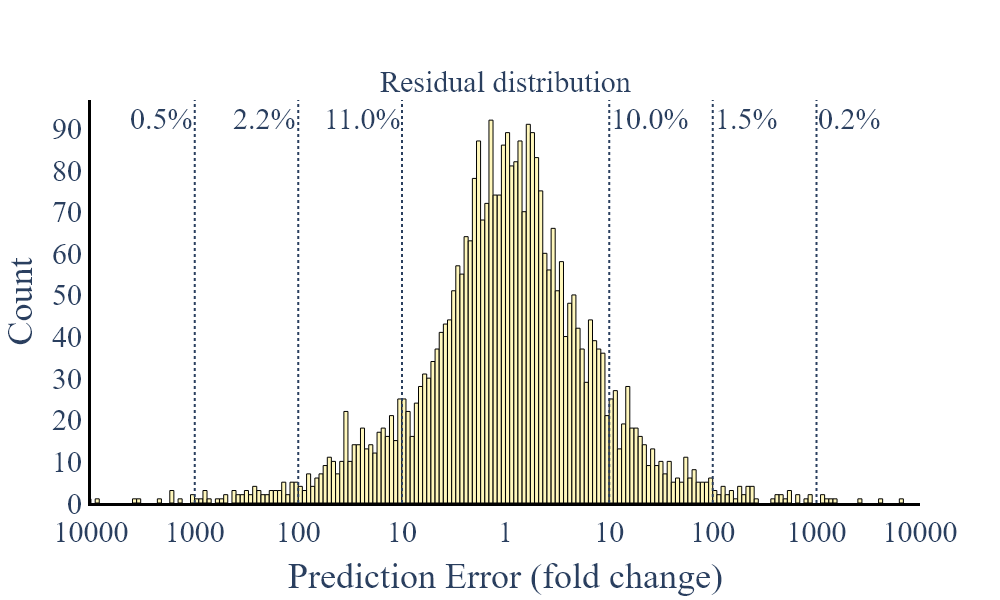

c:\Users\skall\Anaconda3\envs\fishbait\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

divide by zero encountered in log10

c:\Users\skall\Anaconda3\envs\fishbait\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

invalid value encountered in log10



Removed 861 SMILES outside AD
Removed 1941 SMILES outside AD
Removed 0 outside AD rows
Removed 476 SMILES experimental
Removed 701 SMILES experimental
Removed 489 SMILES experimental


c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_qsar.py:115: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_qsar.py:116: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_qsar.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataF

(707, 19)


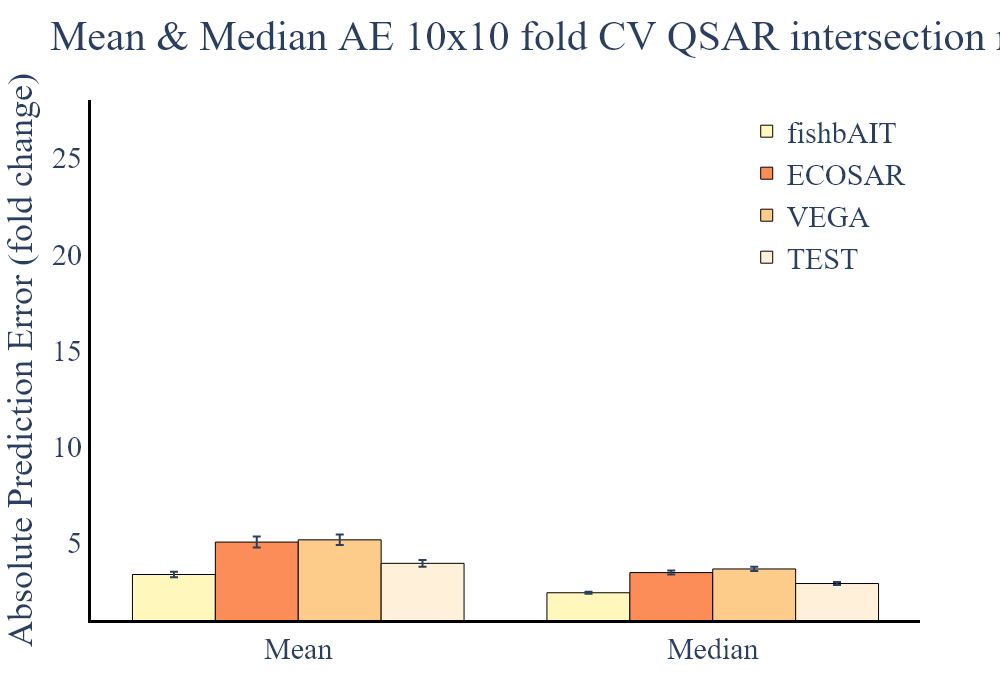

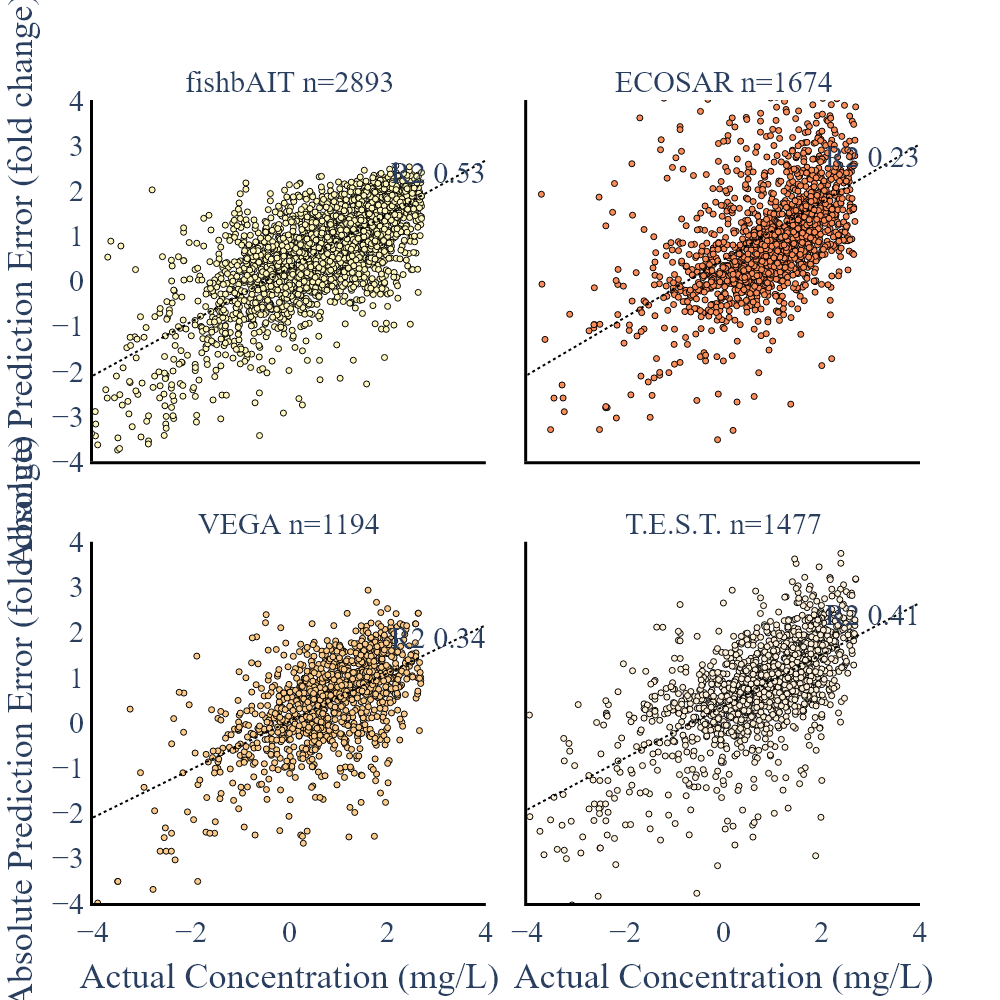

EC50 >1 3757
EC50 >2 1000
EC50 >3 367
ECOSAR >1 1684
ECOSAR >2 662
ECOSAR >3 344
VEGA >1 964
VEGA >2 241
VEGA >3 48
TEST >1 847
TEST >2 195
TEST >3 44


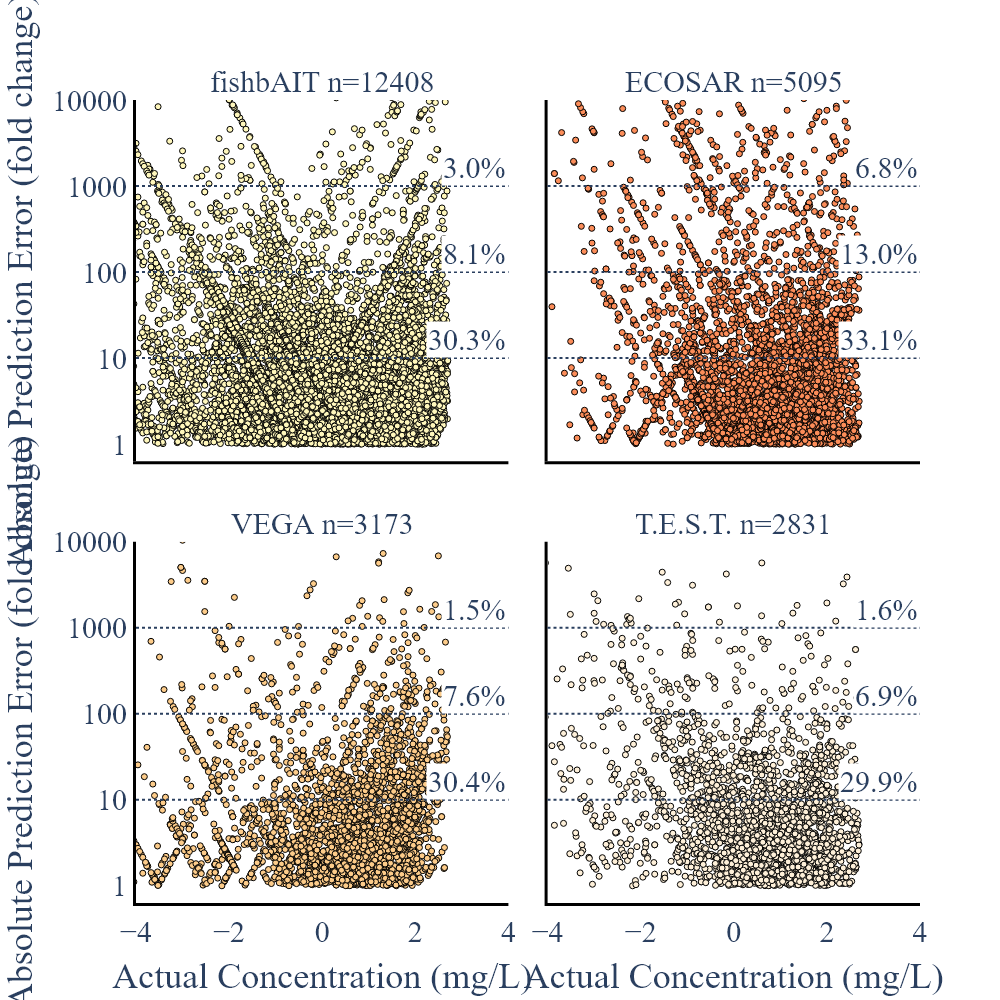

EC50 >1 595
EC50 >2 108
EC50 >3 23
ECOSAR >1 520
ECOSAR >2 167
ECOSAR >3 76
VEGA >1 329
VEGA >2 70
VEGA >3 11
TEST >1 373
TEST >2 79
TEST >3 16


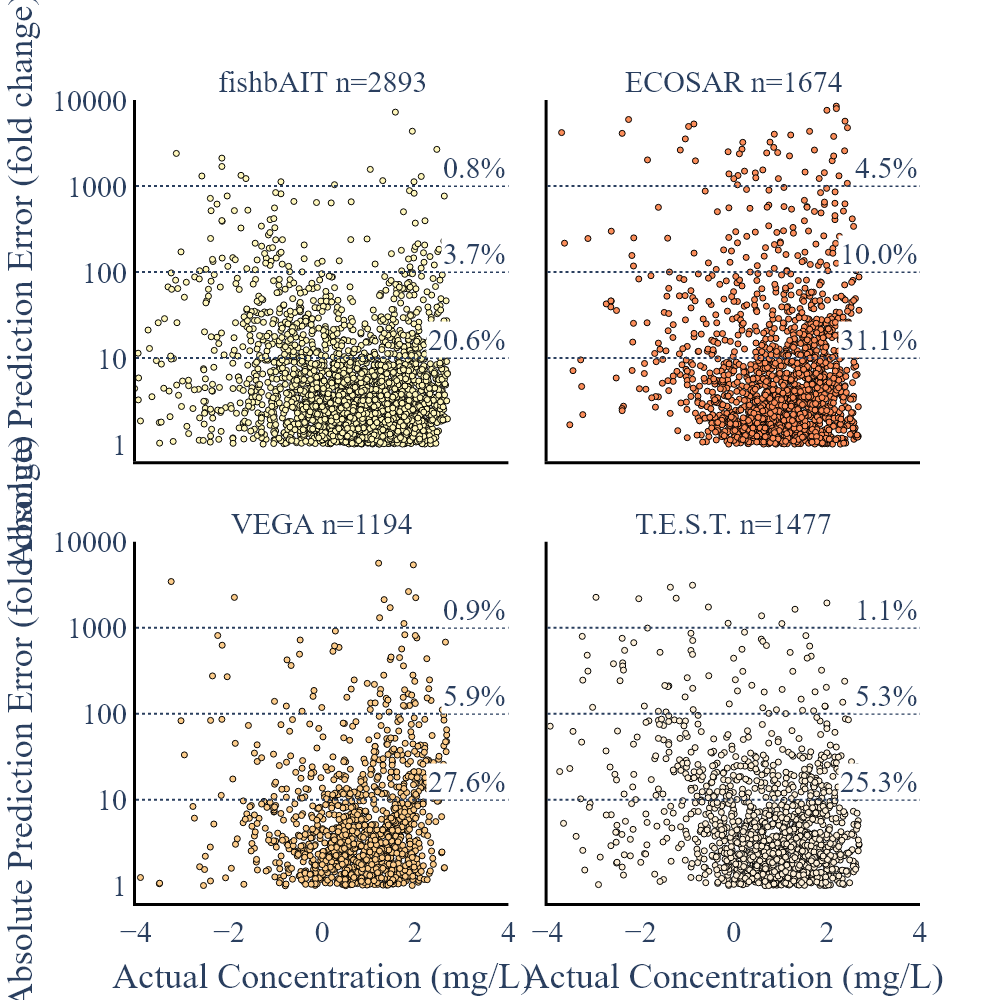

In [9]:
PlotEndpointSpecific(endpoint=ENDPOINT, effect_for_qsar_comp=EFFECT_FOR_QSAR_COMP, name=NAME, inside_AD=INSIDE_AD, durations=DURATIONS, species_group=SPECIES_GROUP, save_figures=True)

In [4]:
ENDPOINT = 'EC50'
NAME = f'{ENDPOINT}_{SPECIES_GROUP}'

In [ ]:
PlotPCA_CLSProjection(savepath=f"./figures_for_publication/{ENDPOINT}/{NAME}_CLS_projection", endpoint=ENDPOINT, species_group=SPECIES_GROUP, flipxaxis=False, flipyaxis=True)

## Manual figure generation

In [53]:
species_group = 'fish'
name = f'EC50_{species_group}'
endpoint = 'EC50'

In [ ]:
PlotKFoldResidualHistUsingWAvgPreds(None, name, endpoint)

In [ ]:
PlotKFoldSingleBarUsingWAvgPreds(None, ec50_name=f'EC50_{species_group}', ec10_name=f'EC10_{species_group}')

### QSAR

In [54]:
avg_predictions = Preprocess10x10Fold(name=name)
avg_predictions = avg_predictions[avg_predictions.effect.isin(['MOR','DVP','ITX','MPH','REP','POP','GRO'])]
weighted_avg_predictions = GroupDataForPerformance(avg_predictions=avg_predictions)

In [55]:
INSIDE_AD = True
DURATIONS = ['short exposure','medium exposure', 'long exposure'] # <= 96h, <= 1week, >1week

In [56]:
# ----------- QSAR ------------------------
ECOSAR, VEGA, TEST = LoadQSAR(endpoint=endpoint, species_group=species_group)

In [57]:
ECOSAR, TEST, VEGA = PrepareQSARData(ECOSAR, TEST, VEGA, inside_AD=INSIDE_AD, remove_experimental=True, species_group=species_group)

c:\Users\skall\Anaconda3\envs\fishbait\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

divide by zero encountered in log10

c:\Users\skall\Anaconda3\envs\fishbait\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

invalid value encountered in log10



Removed 850 SMILES outside AD
Removed 1508 SMILES outside AD
Removed 0 outside AD rows
Removed 397 SMILES experimental
Removed 960 SMILES experimental
Removed 790 SMILES experimental


In [58]:
TEST_dict = dict(zip(TEST.Canonical_SMILES_figures, TEST.value))
VEGA_dict = dict(zip(VEGA.Canonical_SMILES_figures, VEGA.value))
ECOSAR_dict = dict(zip(ECOSAR.Canonical_SMILES_figures, ECOSAR.value))

qsar_preds = MatchQSAR(avg_predictions, ECOSAR_dict, TEST_dict, VEGA_dict, endpoint=endpoint, duration=DURATIONS, species_group=species_group)
qsar_preds[['ECOSAR_residuals','VEGA_residuals','TEST_residuals']] = qsar_preds[['ECOSAR','VEGA','TEST']] - qsar_preds[['labels']].to_numpy()
weighted_avg_qsar_preds = GroupDataForPerformance(qsar_preds)
if (endpoint == 'EC10') | (species_group=='algae'):
    weighted_avg_qsar_preds[['TEST', 'TEST_residuals']] = None

c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_qsar.py:115: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_qsar.py:116: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_qsar.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataF

EC50 >1 408
EC50 >2 60
EC50 >3 8
ECOSAR >1 239
ECOSAR >2 88
ECOSAR >3 36
VEGA >1 200
VEGA >2 38
VEGA >3 5
TEST >1 193
TEST >2 70
TEST >3 18


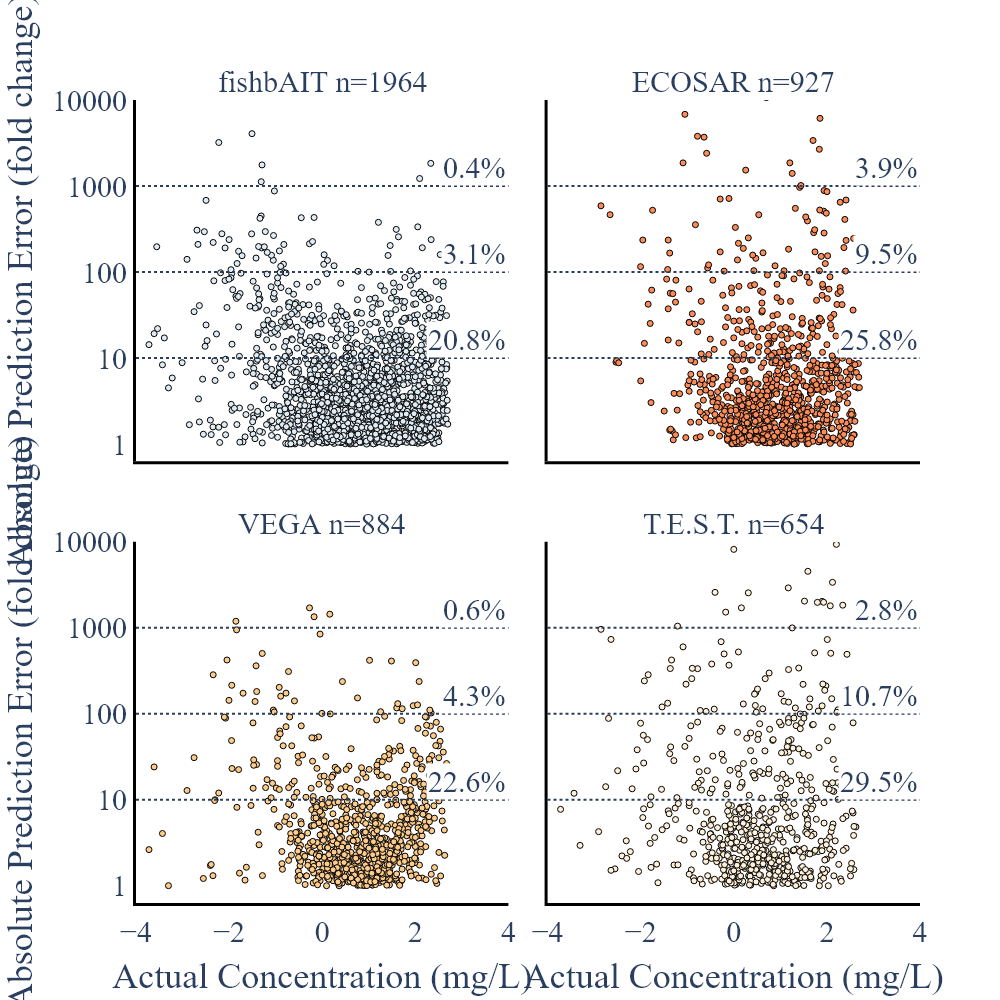

In [59]:
#PlotQSARcompBarUsingWAvgPredsInterersect(None, predictions=weighted_avg_qsar_preds, endpoint=endpoint, species_group=species_group)
#PlotQSARcompScatter(None, predictions=weighted_avg_qsar_preds, endpoint=endpoint)
#PlotQSARresidualScatter(None, predictions=qsar_preds, endpoint=endpoint)
PlotQSARresidualScatter(None, predictions=weighted_avg_qsar_preds, endpoint=endpoint)